# Palmer Penguins: Multiclass Classification Notebook
---
This Jupyter notebook demonstrates a full machine-learning workflow for the Palmer Penguins dataset (UCI / Palmer penguins). It covers:
 - Data loading (UCI URL + seaborn fallback)
 - EDA with narrative and inline plots
 - Data cleaning and preprocessing (imputation, encoding, scaling)
 - Train/test split and stratification
 - Model training with cross-validation and GridSearchCV
 - Comparison of out-of-sample performance and training time
 - SHAP interpretability for the best model (per-class explanations)


### NOTE: run this notebook in a Python environment with the following packages installed:
`pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`, `lightgbm`, `shap (>=0.40)`, `joblib`

In [74]:
%pip install lightgbm shap --upgrade --quiet

In [93]:
"""
# 1. Setup
"""
import time
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# optional LightGBM
try:
    import lightgbm
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False


# optional SHAP
try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False


print('Has LightGBM:', HAS_LGBM)
if HAS_LGBM:
    print('LightGBM version:', lightgbm.__version__)
print('Has SHAP:', HAS_SHAP)
if HAS_SHAP:
    print('SHAP version:', shap.__version__)

Has LightGBM: True
LightGBM version: 4.6.0
Has SHAP: True
SHAP version: 0.48.0


## 2. Load the Data

In this section, we load the Palmer Penguins dataset, which contains measurements of penguin species observed in the Palmer Archipelago, Antarctica.  
The dataset includes biological and physical attributes—such as bill length, flipper length, and body mass—for three species of penguins: **Adélie**, **Chinstrap**, and **Gentoo**.

We first attempt to load the dataset directly from [Allison Horst’s GitHub repository](https://github.com/allisonhorst/palmerpenguins), which provides the canonical version of the Palmer Penguins data in CSV format.  
If that online source is unavailable (e.g., due to a temporary network issue), the code automatically falls back to the version included with the **seaborn** library, ensuring the analysis continues smoothly without interruption.

In [76]:
"""
# 2. Load data
"""
allisonhorst_csv = 'https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv'
try:
    df = pd.read_csv(allisonhorst_csv)
    source = 'allisonhorst GitHub raw CSV'
except Exception:
    # import seaborn as sns
    # df = sns.load_dataset('penguins')
    # source = 'seaborn.load_dataset'

    repo_csv = '../data/penguins.csv'
    df = pd.read_csv(repo_csv)
    source = 'SWB_Predictive_Analytics_Machine_Leanring raw CSV'


print('Data source:', source)
print('Shape:', df.shape)
df.head()

Data source: allisonhorst GitHub raw CSV
Shape: (344, 8)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


With the dataset successfully loaded, let's move on to exploratory data analysis to understand the key characteristics and relationships in the data.


## 3. Exploratory Data Analysis (EDA)

Before we build any models, we explore and visualize the data to understand its structure, distribution, and relationships between variables.

In this section, we:
- Examine the dataset's dimensions, data types, and missing values.
- Visualize numerical feature distributions (e.g., bill length, flipper length, body mass).
- Compare how these features differ across penguin species.
- Explore relationships and correlations between numeric predictors.
- Identify any potential data quality issues (e.g., missing values or outliers).

Through this exploratory analysis, we build an intuition for what distinguishes each penguin species and identify which variables may be most useful for classification.

In [77]:
"""
# 3. EDA
"""
print(df.info())
print('\nValue counts for target (species):')
print(df['species'].value_counts(dropna=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB
None

Value counts for target (species):
species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64


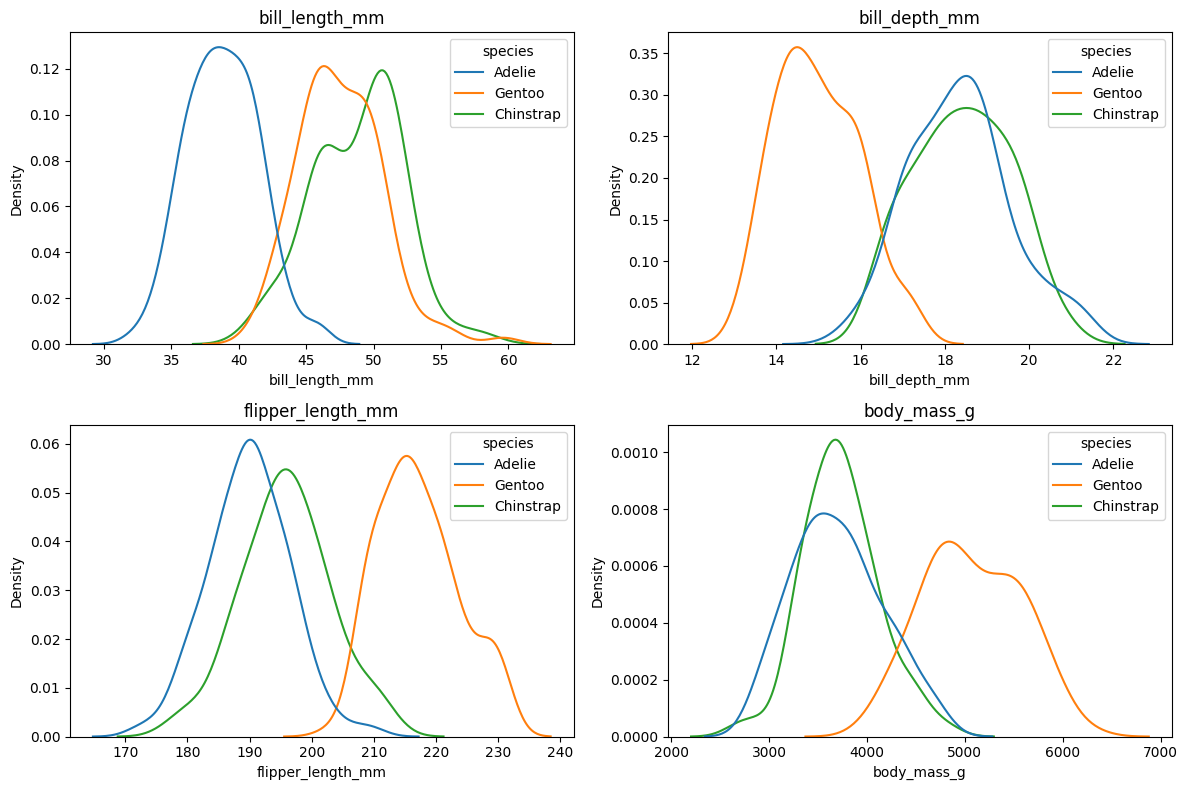

In [78]:
"""
# 3. EDA
"""
num_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(data=df, x=col, hue='species', common_norm=False)
    plt.title(col)
plt.tight_layout()
plt.show()

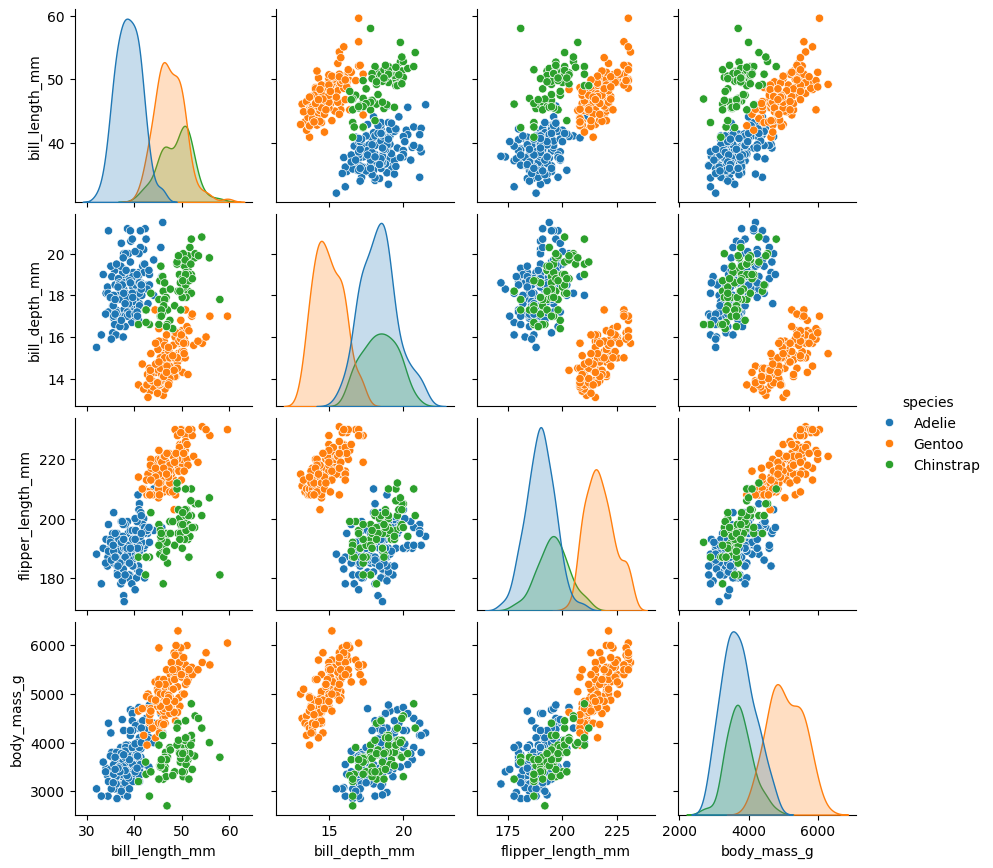

In [79]:
"""
# 3. EDA
"""
sns.pairplot(df.loc[:, num_cols + ['species']].dropna(), hue='species', height=2.2)
plt.show()

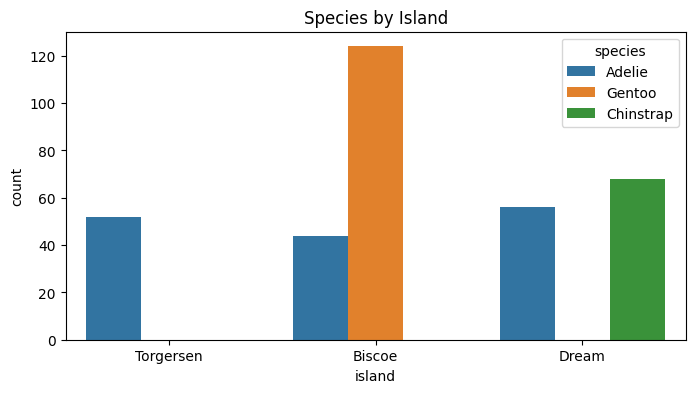

In [80]:
"""
# 3. EDA
"""
plt.figure(figsize=(8, 4))
sns.countplot(x='island', hue='species', data=df)
plt.title('Species by Island')
plt.show()

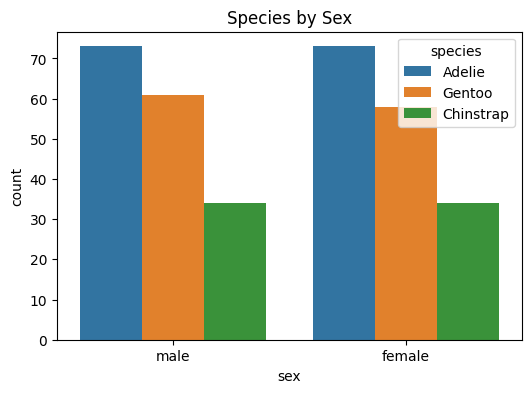

In [81]:
"""
# 3. EDA
"""
plt.figure(figsize=(6, 4))
sns.countplot(x='sex', hue='species', data=df)
plt.title('Species by Sex')
plt.show()

Our exploratory analysis gives us a solid understanding of the data's structure and potential issues.  

Next, we'll clean and preprocess the dataset to ensure it's ready for modeling.

## 4. Data Cleaning and Preprocessing

Raw data typically requires cleaning and transformation before it can be used effectively for modeling.  
In this section, we prepare the data for training by performing the following steps:

1. **Handling Missing Values:**  
   Impute missing numeric values with the median and categorical values with the mode, preserving overall data structure.

2. **Encoding Categorical Variables:**  
   Convert string-based features such as `island` and `sex` into numerical form using one-hot encoding.

3. **Feature Scaling:**  
   Standardize numeric predictors (mean = 0, standard deviation = 1) to ensure models like logistic regression and SVM are not biased by variable scale differences.

4. **Train-Test Split:**  
   Split the dataset into a training and testing set (e.g., 70/30) using stratified sampling to maintain class balance across penguin species.

After preprocessing, the cleaned dataset will be ready for fitting a variety of classification models.

In [82]:
"""
# 4. Preprocessing
"""
df = df.dropna(subset=['species']).reset_index(drop=True)

TARGET = 'species'
y = df[TARGET]

X = df[['island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']]


print(y.shape, X.shape)

(344,) (344, 6)


In [83]:
num_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric features: {num_features}\n")
print(f"Categorical features: {cat_features}")

Numeric features: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

Categorical features: ['island', 'sex']


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(240, 6) (104, 6) (240,) (104,)


In [85]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], verbose_feature_names_out=False)

Now that our dataset is preprocessed and standardized, we can begin training classification models to predict penguin species.

## 5. Modeling and Baseline Comparison

Now that the data is clean and standardized, we train several classification algorithms to predict the penguin species.

We will compare a range of models representing different algorithmic families:
- **Logistic Regression** — a linear baseline model.
- **Random Forest** — an ensemble of decision trees with bootstrap aggregation.
- **Gradient Boosting (LightGBM)** — a powerful boosting-based ensemble method.
- **Support Vector Machine (SVM)** — a margin-based classifier.

Each model is trained and evaluated using cross-validation to estimate its out-of-sample accuracy.  

We also record training time to understand the trade-offs between model complexity, performance, and computational efficiency.

In [86]:
"""
# 5. Models & Grids
"""
models = {}
param_grids = {}


models['LogisticRegression'] = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=5000, n_jobs=-1)
param_grids['LogisticRegression'] = {'classifier__C': [0.01, 0.1, 1.0, 10.0]}


models['RandomForest'] = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grids['RandomForest'] = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [None, 5, 10, 20]
}


if HAS_LGBM:
    models['LightGBM'] = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
    param_grids['LightGBM'] = {
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [-1, 5, 10],
        'classifier__n_estimators': [100, 300, 500]
    }


models['SVM'] = SVC(kernel='rbf', probability=True)
param_grids['SVM'] = {'classifier__C': [0.1, 1, 10], 'classifier__gamma': ['scale', 'auto']}


pprint(f"Models: {models}\n")
pprint(f"Parameter grids: {param_grids}")

("Models: {'LogisticRegression': LogisticRegression(max_iter=5000, "
 "multi_class='multinomial', n_jobs=-1,\n"
 "                   solver='saga'), 'RandomForest': "
 "RandomForestClassifier(n_jobs=-1, random_state=42), 'LightGBM': "
 "LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1), 'SVM': "
 'SVC(probability=True)}\n')
("Parameter grids: {'LogisticRegression': {'classifier__C': [0.01, 0.1, 1.0, "
 "10.0]}, 'RandomForest': {'classifier__n_estimators': [100, 300, 500], "
 "'classifier__max_depth': [None, 5, 10, 20]}, 'LightGBM': "
 "{'classifier__learning_rate': [0.01, 0.05, 0.1], 'classifier__max_depth': "
 "[-1, 5, 10], 'classifier__n_estimators': [100, 300, 500]}, 'SVM': "
 "{'classifier__C': [0.1, 1, 10], 'classifier__gamma': ['scale', 'auto']}}")


Having established baseline performance across multiple algorithms, our next step is to fine-tune the most promising model to maximize its predictive accuracy.


## 6. Hyperparameter Tuning with GridSearchCV

After identifying promising baseline models, we fine-tune their key hyperparameters using scikit-learn's `GridSearchCV`.

For the **LightGBM classifier**, we focus on:
- `learning_rate`: controls how much each tree contributes to the ensemble.
- `max_depth`: limits the depth of each tree, controlling model complexity and overfitting.

The grid search systematically evaluates multiple combinations of these parameters using cross-validation.

This stage helps us select the most accurate and efficient model configuration for our data.


=== LogisticRegression ===
Best params: {'classifier__C': 10.0}
Accuracy: 0.9807692307692307
Training time: 0.73 seconds.


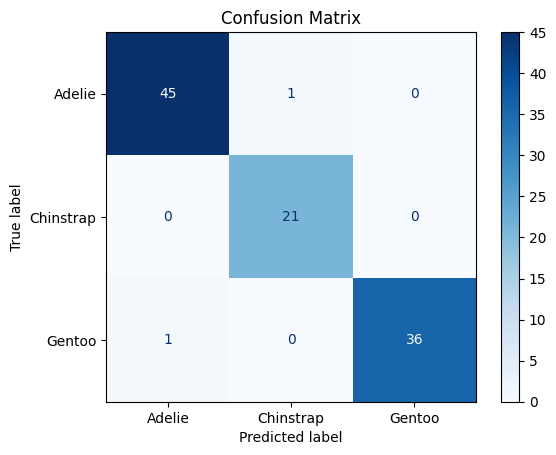

Classification Report:

              precision    recall  f1-score   support

      Adelie       0.98      0.98      0.98        46
   Chinstrap       0.95      1.00      0.98        21
      Gentoo       1.00      0.97      0.99        37

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104


=== RandomForest ===
Best params: {'classifier__max_depth': None, 'classifier__n_estimators': 300}
Accuracy: 0.9903846153846154
Training time: 35.3 seconds.


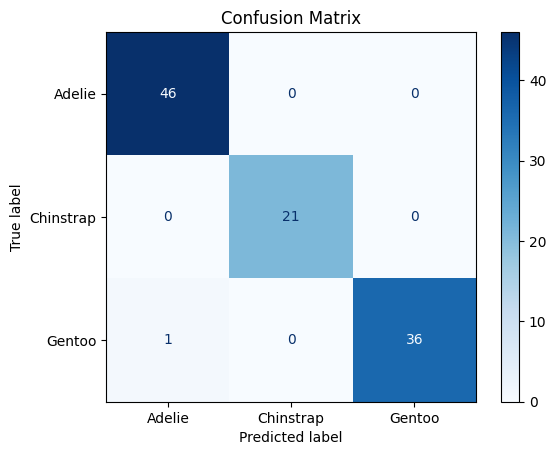

Classification Report:

              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        46
   Chinstrap       1.00      1.00      1.00        21
      Gentoo       1.00      0.97      0.99        37

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104


=== LightGBM ===
Best params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': -1, 'classifier__n_estimators': 300}
Accuracy: 0.9903846153846154
Training time: 45.86 seconds.


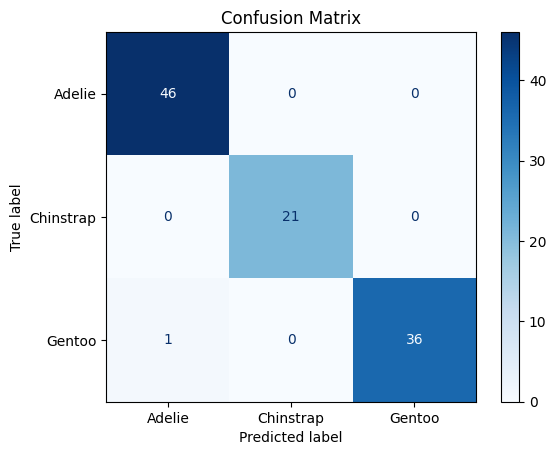

Classification Report:

              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        46
   Chinstrap       1.00      1.00      1.00        21
      Gentoo       1.00      0.97      0.99        37

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104


=== SVM ===
Best params: {'classifier__C': 1, 'classifier__gamma': 'scale'}
Accuracy: 0.9903846153846154
Training time: 0.75 seconds.


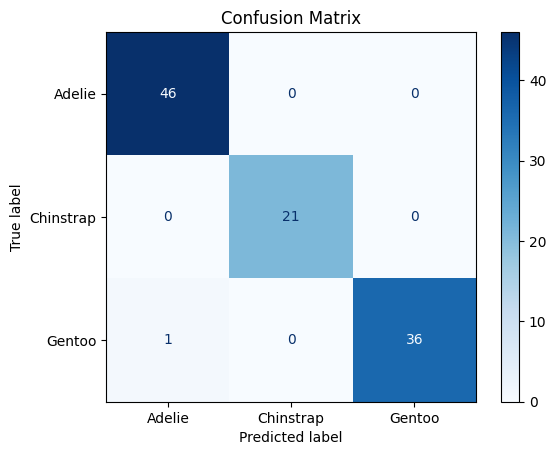

Classification Report:

              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        46
   Chinstrap       1.00      1.00      1.00        21
      Gentoo       1.00      0.97      0.99        37

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104


Models Comparison:
                model  accuracy  precision    recall        f1  train_time_s
1        RandomForest  0.990385   0.992908  0.990991  0.991850     35.297183
2            LightGBM  0.990385   0.992908  0.990991  0.991850     45.861311
3                 SVM  0.990385   0.992908  0.990991  0.991850      0.748393
0  LogisticRegression  0.980769   0.977602  0.983745  0.980435      0.729897


In [102]:
"""
# 6. Train & Compare
"""
results = []
for name, estimator in models.items():
    print(f"\n=== {name} ===")
    pipe = Pipeline([('preprocessor', preprocessor), ('classifier', estimator)])
    grid = GridSearchCV(pipe, param_grid=param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    start = time.time()
    grid.fit(X_train, y_train)
    elapsed = time.time() - start
    best = grid.best_estimator_
    y_pred = best.predict(X_test)


    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')


    print('Best params:', grid.best_params_)
    print('Accuracy:', acc)
    print(f'Training time: {np.round(elapsed, 2)} seconds.')


    # 1) Metrics results
    results.append({
        'model': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'train_time_s': elapsed,
    })


    # 2) Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_ if hasattr(pipe, "classes_") else best.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=pipe.classes_ if hasattr(pipe, "classes_") else best.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # 3) Classification report
    report = classification_report(y_test, y_pred, target_names=pipe.classes_ if hasattr(pipe, "classes_") else best.classes_)
    print("Classification Report:\n")
    print(report)


results_df = pd.DataFrame(results).sort_values('accuracy', ascending=False)
print("\nModels Comparison:")
print(results_df)

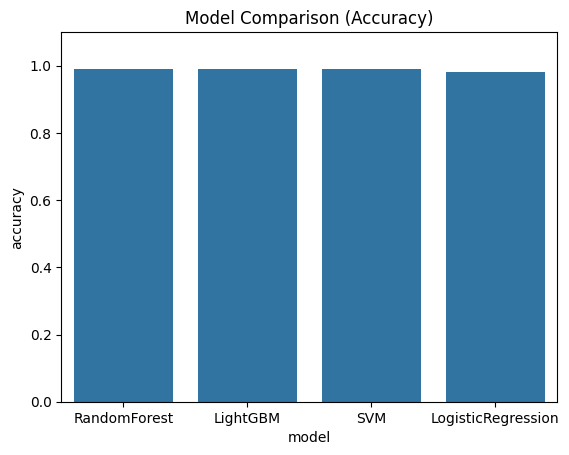

In [103]:
"""
# 6. Train & Compare
"""
sns.barplot(x='model', y='accuracy', data=results_df.sort_values(by='accuracy', ascending=False))
plt.title('Model Comparison (Accuracy)')
plt.ylim(0, 1.1)
plt.show()

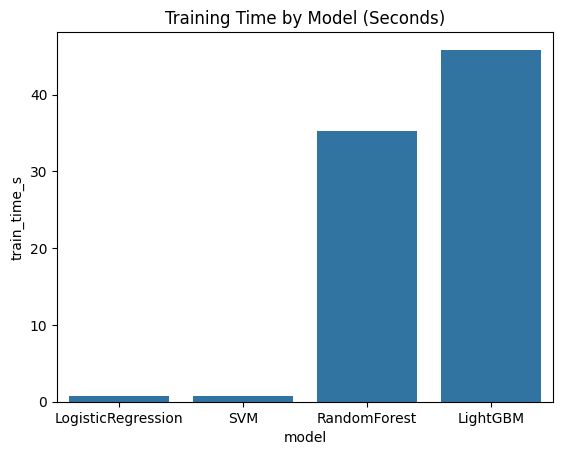

In [104]:
"""
# 6. Train & Compare
"""
sns.barplot(x='model', y='train_time_s', data=results_df.sort_values(by='train_time_s', ascending=True))
plt.title('Training Time by Model (Seconds)')
plt.show()

In [105]:
"""
# 6. Train & Compare
"""
best_model_name = results_df.iloc[0]['model']
print('Best model:', best_model_name)

Best model: RandomForest


Once our final model has been fine-tuned, we'll interpret its predictions using SHAP to better understand how each feature contributes to penguin species classification.


## 7. Model Interpretability with SHAP

While predictive accuracy is important, understanding *why* a model makes its predictions is equally valuable — especially for scientific and policy-related data like ecological research.

We use **SHAP (SHapley Additive exPlanations)** to interpret our best-performing model (RandomForest).  

SHAP values quantify each feature's contribution to the model's predictions for individual observations and overall.

In this section, we:
- Compute SHAP values for a representative subset of the data.
- Visualize **global feature importance** to see which variables most strongly influence species classification.
- Optionally inspect **individual prediction explanations** (e.g., using waterfall or force plots).

These insights allow us to connect model predictions back to biological intuition — for instance, how bill length or flipper size help differentiate between penguin species.

Running robust SHAP explanations...
Best model: RandomForest


ExactExplainer explainer: 201it [00:26,  4.65it/s]



Single-output model detected (binary/regression).


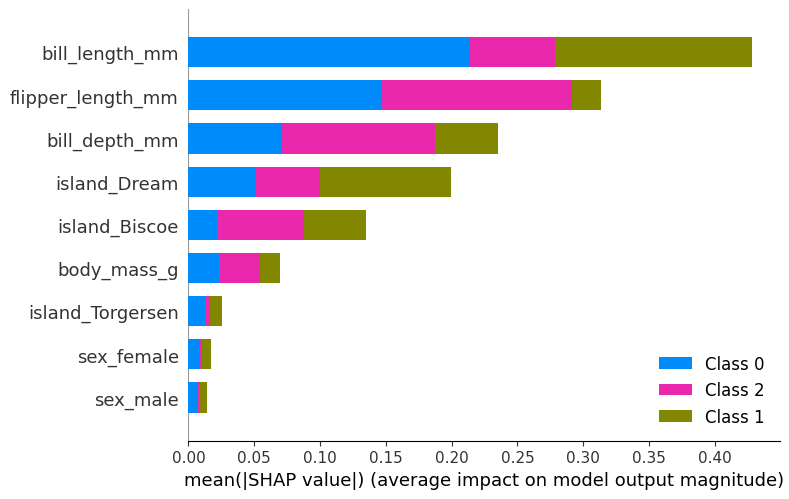

In [106]:
"""
# 7. SHAP Interpretability
"""
# --- Robust SHAP Interpretability for Binary and Multiclass Classifiers ---
if not HAS_SHAP:
    print("SHAP not installed; skipping interpretability section.")
else:
    import shap
    import pandas as pd
    import numpy as np
    from sklearn.pipeline import Pipeline

    print("Running robust SHAP explanations...")

    # 1) Identify the best model
    best_model_name = results_df.iloc[0]['model']
    print("Best model:", best_model_name)

    # 2) Safely retrieve the estimator
    model_entry = models.get(best_model_name)
    if model_entry is None:
        raise KeyError(f"Model '{best_model_name}' not found in models dictionary.")
    estimator = model_entry[0] if isinstance(model_entry, (list, tuple)) else model_entry

    # 3) Build a pipeline and fit it on training data
    pipe = Pipeline([('preprocessor', preprocessor), ('classifier', estimator)])
    pipe.fit(X_train, y_train)
    fitted_clf = pipe.named_steps['classifier']
    fitted_preproc = pipe.named_steps['preprocessor']

    # 4) Prepare a representative sample for SHAP
    n_sample = min(200, len(X_train))
    X_sample = X_train.sample(n=n_sample, random_state=42)
    X_trans_sample = fitted_preproc.transform(X_sample)

    # 5) Get feature names after preprocessing
    try:
        feature_names = fitted_preproc.get_feature_names_out()
    except Exception:
        # fallback if sklearn version does not support get_feature_names_out()
        numeric_names = num_features
        try:
            ohe = fitted_preproc.named_transformers_['cat'].named_steps['onehot']
            ohe_names = ohe.get_feature_names_out(cat_features)
        except Exception:
            ohe_names = [f"{c}_{i}" for c in cat_features for i in range(1)]
        feature_names = list(numeric_names) + list(ohe_names)

    X_trans_sample_df = pd.DataFrame(X_trans_sample, columns=feature_names)

    # 6) Create a predict_proba wrapper for SHAP
    def predict_proba_wrapper(X_in):
        if isinstance(X_in, pd.DataFrame):
            arr = X_in.values
        else:
            arr = np.asarray(X_in)
        return fitted_clf.predict_proba(arr)

    # 7) Create SHAP explainer with the sample as background
    explainer = shap.Explainer(
        predict_proba_wrapper,
        X_trans_sample_df,
        output_names=[str(c) for c in fitted_clf.classes_]
    )

    # 8) Compute SHAP values on the same sample
    shap_exp = explainer(X_trans_sample_df)

    # 9) Generate per-class summary plots
    if isinstance(shap_exp, list):
        # Multiclass: list of Explanation objects (one per class)
        for i, class_exp in enumerate(shap_exp):
            class_name = fitted_clf.classes_[i]
            print(f"\nSHAP summary for class '{class_name}'")
            shap.summary_plot(class_exp, X_trans_sample_df, show=True)
    else:
        # Binary or regression
        print("\nSingle-output model detected (binary/regression).")
        shap.summary_plot(shap_exp, X_trans_sample_df, show=True)

## 8. Conclusion

We've completed a full end-to-end machine learning workflow:
- Loaded and explored the Palmer Penguins dataset  
- Cleaned and preprocessed the data  
- Trained and tuned multiple classifiers  
- Interpreted the final model using SHAP  

The analysis highlights how modern ML tools like LightGBM and SHAP can provide both high accuracy and transparent interpretability — helping us not only predict penguin species but also understand the traits that distinguish them.